# **Neural Style Transfer**

Перенос стиля (style transfer) - интересное и креативное использование свёрточных нейронных сетей. Взяв контент с одного изображения и стиль от второго, нейронная сеть объединяет их в одно художественное произведение.

## Dataset

Для обучения модели используется датасет - COCO2014, скачать который можно по ссылке: https://academictorrents.com/details/f993c01f3c268b5d57219a38f8ec73ee7524421a

Обучающая выборка данного датасета состоит из 82784 изображений на произвольную тему. Название каждого изображения подчиняется данному правилу: СOCO_train2014_{числовой номер} (например, COCO_train2014_000000001332).

Перед обучением нужно перевести все изображения в формат png, а также изменить их размер на 256x256. Это можно сделать при помощи командной строки терминала. На Mac OS нужно использовать данные команды (находясь при этом в папке с нужными изображениями):

In [6]:
# for i in *.jpg; do sips -s format png -s formatOptions 100 "${i}" --out "${i%jpg}png"; done

# Все файлы с форматом JPG переводятся в формат PNG с качеством 100%

In [7]:
# sips -z 256 256 *.png

# Все файлы с форматом PNG изменяют размер на 256x256 

При изменении формата и размера я столкнулась с проблемой, заключающейся в том, что терминал не мог выполнить данные команды, поскольку объектов было слишком много. Решение проблемы - поделить наш набор данных по принципу "на какую цифру заканчивается название файла". Таким образом, набор данных при каждом запуске составлял 1/10 изначального и с таким количеством данных терминал справился.

Проверка на битые изображения находится в самой программе при помощи библиотеки Pillow. По умолчанию, Pillow, когда видит изображения, которые не соответствуют формату до конца, просто кидает исключение. Поэтому, так как для открытия изображения используется библиотека Pillow, а именно команда open из Image (пример из кода: Image.open(args.style_image)), то попадание в обучение модели битых изображений исключается.

Выведем несколько изображений, чтобы наглядно посмотреть на состав нашего получившегося датасета:

In [1]:
import matplotlib.pyplot as plt
from PIL import Image

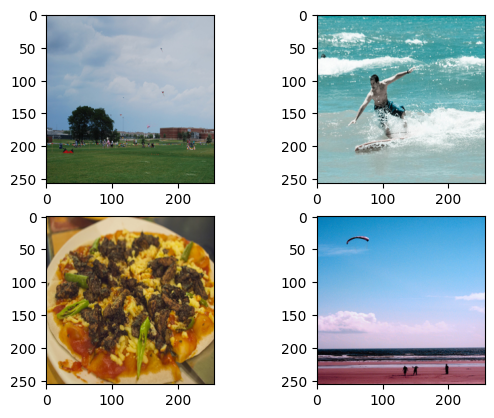

In [12]:
plt.subplot(2, 2, 1)
plt.imshow(Image.open('/Users/macbookpro/coco2014/train/train2014/COCO_train2014_000000000149.png'))
plt.subplot(2, 2, 2)
plt.imshow(Image.open('/Users/macbookpro/coco2014/train/train2014/COCO_train2014_000000194456.png'))
plt.subplot(2, 2, 3)
plt.imshow(Image.open('/Users/macbookpro/coco2014/train/train2014/COCO_train2014_000000000194.png'))
plt.subplot(2, 2, 4)
plt.imshow(Image.open('/Users/macbookpro/coco2014/train/train2014/COCO_train2014_000000001200.png'))
plt.show()

## Выбор модели

Чтобы получить представление контента и стиля изображения, нужно посмотреть на промежуточные слои модели. Промежуточные слои представляют собой карты признаков, которые по мере углубления становятся более упорядоченными. В этом случае будем использовать сетевую архитектуру VGG16 - предварительно подготовленную свёрточную нейронную сеть выделения признаков изображений.

Данная архитектура является отличным строительным блоком для обучения6 её легко реализовать, однако она имеет и несколько недостатков: медленная скорость обучения, большой вес самой архитектуры.

## Код для обучения модели

Рассмотрим код обучения модели, представленной файлом train.py. Подключаем нужные библиотеки:

In [2]:
import argparse
import os
import sys
import random
from PIL import Image
import numpy as np
import torch
import glob
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import save_image
from modelss import TransformerNet, VGG16
from utils import *

Процедура оценки модели и сохранения изображений в процессе обучения:

In [18]:
def save_sample(batches_done):
    """ Evaluates the model and saves image samples """
    transformer.eval()
    with torch.no_grad():
        output = transformer(image_samples.to(device))
    image_grid = denormalize(torch.cat((image_samples.cpu(), output.cpu()), 2))
    save_image(image_grid, f"images/outputs/{style_name}-training/{batches_done}.jpg", nrow=4)
    transformer.train()

Задаём аргументы, которые можно подать при запуске программы. Создаём необходимые папки для дальнейших результатов обучения модели, загрузчик данных для обучающих данных. Определяем нейронную сеть, загружаем модель. Определяем оптимизацию и потерю. Загружаем изображение стиля, извлекаем функцию стиля.

Также из датасета выбирается рандомным образом 8 изображений, к которым с какой-то периодичностью будет применяться прогресс обучения модели в данный момент и они будут сохраняться в созданной программе папке images в папке outputs. Благодаря этому можно будет увидеть процесс обучения модели на зафиксированных изображениях.

Начинаем обучение модели, которое происходит с помощью цикла по числу эпох. В цикле также извлекаем функции стиля, вычисляем потерю контента и потерю стиля.

In [ ]:
'''
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Parser for Fast-Neural-Style")
    parser.add_argument("--dataset_path", type=str, required=True, help="path to training dataset")
    parser.add_argument("--style_image", type=str, default="style-images/mosaic.jpg", help="path to style image")
    parser.add_argument("--epochs", type=int, default=1, help="Number of training epochs")
    parser.add_argument("--batch_size", type=int, default=4, help="Batch size for training")
    parser.add_argument("--image_size", type=int, default=256, help="Size of training images")
    parser.add_argument("--style_size", type=int, help="Size of style image")
    parser.add_argument("--lambda_content", type=float, default=1e5, help="Weight for content loss")
    parser.add_argument("--lambda_style", type=float, default=1e10, help="Weight for style loss")
    parser.add_argument("--lr", type=float, default=1e-3, help="Learning rate")
    parser.add_argument("--checkpoint_model", type=str, help="Optional path to checkpoint model")
    parser.add_argument("--checkpoint_interval", type=int, default=2000, help="Batches between saving model")
    parser.add_argument("--sample_interval", type=int, default=1000, help="Batches between saving image samples")
    args = parser.parse_args()

    style_name = args.style_image.split("/")[-1].split(".")[0]
    os.makedirs(f"images/outputs/{style_name}-training", exist_ok=True)
    os.makedirs(f"checkpoints", exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create dataloader for the training data
    train_dataset = datasets.ImageFolder(args.dataset_path, train_transform(args.image_size))
    dataloader = DataLoader(train_dataset, batch_size=args.batch_size)

    # Defines networks
    transformer = TransformerNet().to(device)
    vgg = VGG16(requires_grad=False).to(device)

    # Load checkpoint model if specified
    if args.checkpoint_model:
        transformer.load_state_dict(torch.load(args.checkpoint_model))

    # Define optimizer and loss
    optimizer = Adam(transformer.parameters(), args.lr)
    l2_loss = torch.nn.MSELoss().to(device)

    # Load style image
    style = style_transform(args.style_size)(Image.open(args.style_image))
    style = style.repeat(args.batch_size, 1, 1, 1).to(device)

    # Extract style features
    features_style = vgg(style)
    gram_style = [gram_matrix(y) for y in features_style]

    # Sample 8 images for visual evaluation of the model
    image_samples = []
    for path in random.sample(glob.glob(f"{args.dataset_path}/*/*.png"), 8):
        image_samples += [style_transform(args.image_size)(Image.open(path))]
    image_samples = torch.stack(image_samples)

    for epoch in range(args.epochs):
        epoch_metrics = {"content": [], "style": [], "total": []}
        for batch_i, (images, _) in enumerate(dataloader):
            optimizer.zero_grad()

            images_original = images.to(device)
            images_transformed = transformer(images_original)

            # Extract features
            features_original = vgg(images_original)
            features_transformed = vgg(images_transformed)

            # Compute content loss as MSE between features
            content_loss = args.lambda_content * l2_loss(features_transformed.relu2_2, features_original.relu2_2)

            # Compute style loss as MSE between gram matrices
            style_loss = 0
            for ft_y, gm_s in zip(features_transformed, gram_style):
                gm_y = gram_matrix(ft_y)
                style_loss += l2_loss(gm_y, gm_s[: images.size(0), :, :])
            style_loss *= args.lambda_style

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            epoch_metrics["content"] += [content_loss.item()]
            epoch_metrics["style"] += [style_loss.item()]
            epoch_metrics["total"] += [total_loss.item()]

            sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [Content: %.2f (%.2f) Style: %.2f (%.2f) Total: %.2f (%.2f)]"
                % (
                    epoch + 1,
                    args.epochs,
                    batch_i,
                    len(train_dataset),
                    content_loss.item(),
                    np.mean(epoch_metrics["content"]),
                    style_loss.item(),
                    np.mean(epoch_metrics["style"]),
                    total_loss.item(),
                    np.mean(epoch_metrics["total"]),
                )
            )

            batches_done = epoch * len(dataloader) + batch_i + 1
            if batches_done % args.sample_interval == 0:
                save_sample(batches_done)
                style_name = os.path.basename(args.style_image).split(".")[0]
                torch.save(transformer.state_dict(), f"checkpoints/{style_name}_#{batches_done}.pth")
            
            print('  ', args.checkpoint_interval, batches_done)
            if args.checkpoint_interval > 0 and batches_done % args.checkpoint_interval == 0:
                style_name = os.path.basename(args.style_image).split(".")[0]
                torch.save(transformer.state_dict(), f"checkpoints/{style_name}_@{batches_done}.pth")
'''

Запуск программы для обучения модели происходит через терминал при помощи команды:

In [ ]:
# Общий вид запуска программы обучения:
# python3 train.py --dataset_path {path-to-dataset} --style_image {path-to style-image}

# Конкретный пример запуска обучения:
# python3 train.py --dataset_path /Users/macbookpro/coco2014/train --style_image /Users/macbookpro/style-images/kandinsky.jpg --epochs 100 --batch_size 4 --image_size 256

## Обучаемые стили

Я обучила модель на пяти различных произведениях искусств с интересными стилями. Обучение каждому стилю состояло из 10000 итераций. Посмотрим на стилевые изображения:

1) Знаменитая картина "Большая волна в Канагаве" японского художника Кацусики Хокусая:

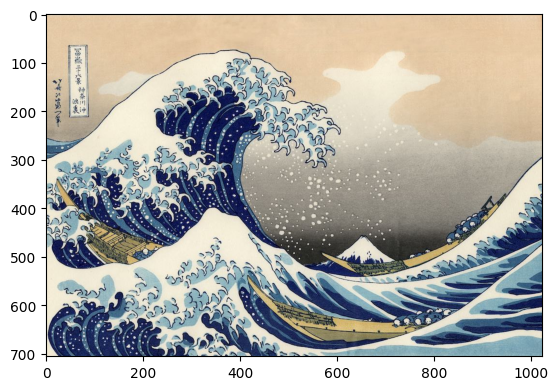

In [8]:
plt.subplot(1, 1, 1)
plt.imshow(Image.open('/Users/macbookpro/style-images/wave.jpg'))
plt.show()

2) Известная картина "Океан" русского художника Ивана Константиновича Айвазовского:

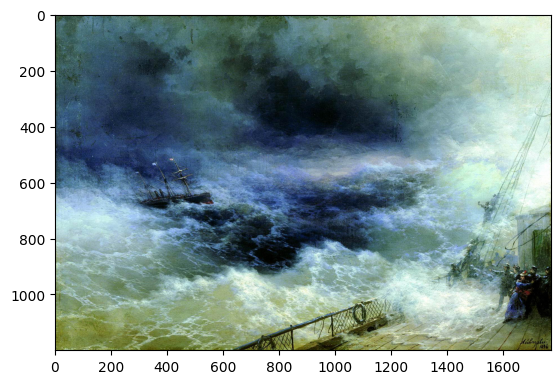

In [4]:
plt.subplot(1, 1, 1)
plt.imshow(Image.open('/Users/macbookpro/style-images/aivazovsky-ocean.jpg'))
plt.show()

3) Известная картина "Композиция VII" русского художника Василия Васильевича Кандинского:

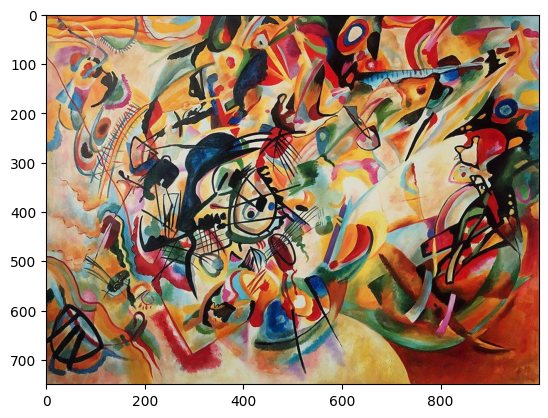

In [4]:
plt.subplot(1, 1, 1)
plt.imshow(Image.open('/Users/macbookpro/style-images/kandinskyVII.jpeg'))
plt.show()

4) Акварельный пейзаж:

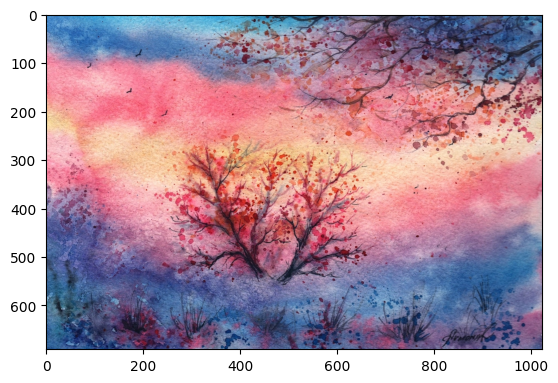

In [10]:
plt.subplot(1, 1, 1)
plt.imshow(Image.open('/Users/macbookpro/style-images/akvarel.jpg'))
plt.show()

5) Необычная картина "Начало" мексиканского художника Эдуардо Родригеза Кальзадо:

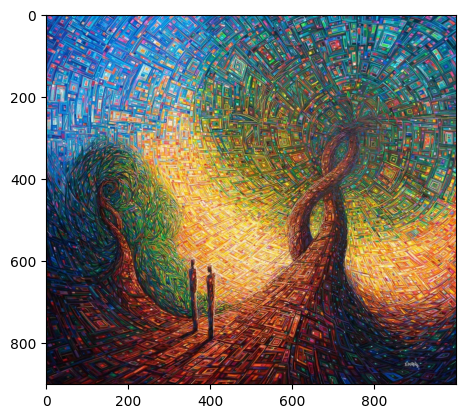

In [11]:
plt.subplot(1, 1, 1)
plt.imshow(Image.open('/Users/macbookpro/style-images/kalzado.jpg'))
plt.show()

## Процесс обучения модели

Обучение одному стилю состоит из 10000 итераций и занимает по времени примерно 23 часа. Мне стало интересно провести обучение модели на собственном устройстве, ноутбук MacBook Pro c 2,9 GHz 2-ядерным процессором Intel Core i5 успешно справился с этой задачи за приемлимое время обучения.

Перед запуском обучения программа из датасета выбирает 8 рандомных изображений для наблюдения за процессом обучения (периодически эти изображения проходят через модель с её прогрессом обучения на данный момент и сохраняются на компьютере). На примере обучения стилю картины "Начало" мексиканского художника Эдуардо Родригеза Кальзадо посмотрим на этот прогресс: 

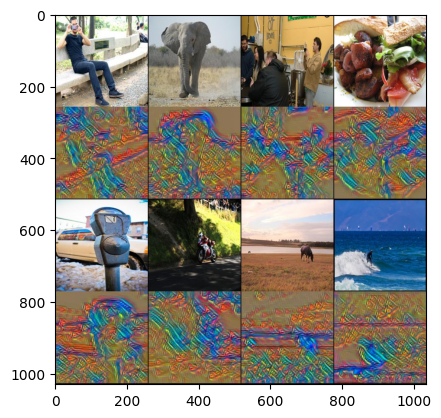

In [25]:
plt.subplot(1, 1, 1)
plt.imshow(Image.open('/Users/macbookpro/images/outputs/kalzado-training/500.jpg'))
plt.show()

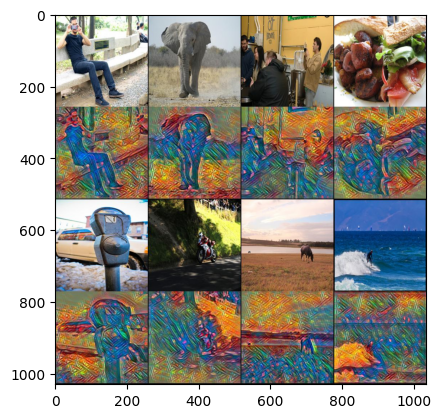

In [27]:
plt.subplot(1, 1, 1)
plt.imshow(Image.open('/Users/macbookpro/images/outputs/kalzado-training/2000.jpg'))
plt.show()

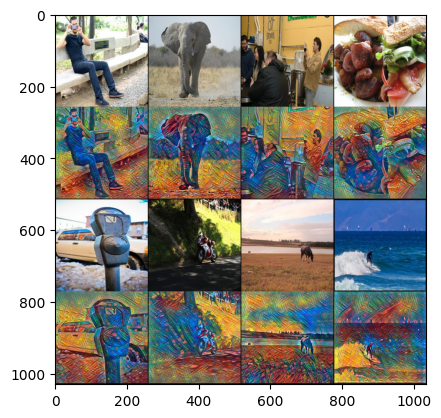

In [28]:
plt.subplot(1, 1, 1)
plt.imshow(Image.open('/Users/macbookpro/images/outputs/kalzado-training/5000.jpg'))
plt.show()

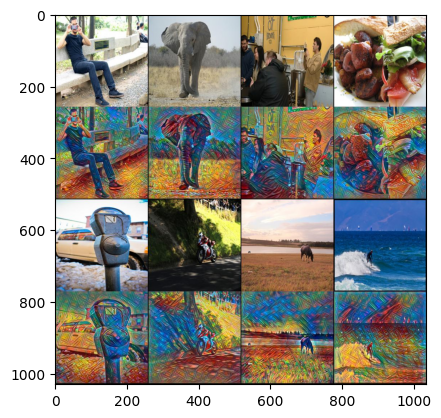

In [29]:
plt.subplot(1, 1, 1)
plt.imshow(Image.open('/Users/macbookpro/images/outputs/kalzado-training/10000.jpg'))
plt.show()

## Результаты обучения

Посмотрим на результат обучения моделей каждого из стилей на изображении, которое можно скачать по ссылке: https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.theartnewspaper.ru%2Fposts%2F3062%2F&psig=AOvVaw0SOcBEWOzHM7HYQ7UqAqmx&ust=1667938565400000&source=images&cd=vfe&ved=0CA0QjRxqFwoTCOiUqMDxnPsCFQAAAAAdAAAAABAE:

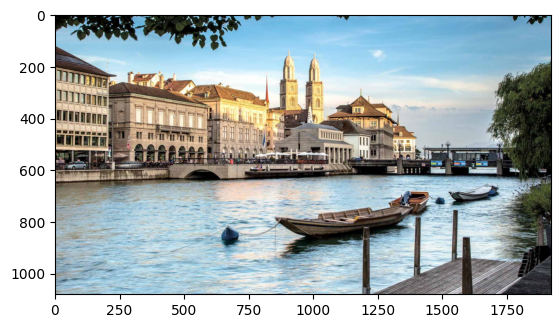

In [12]:
plt.subplot(1, 1, 1)
plt.imshow(Image.open('/Users/macbookpro/city.jpeg'))
plt.show()

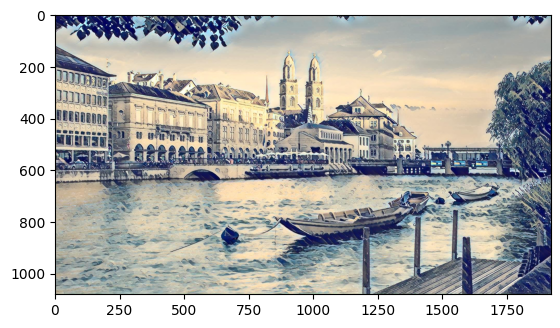

In [16]:
plt.subplot(1, 1, 1)
plt.imshow(Image.open('/Users/macbookpro/wave-stylized-city.jpeg'))
plt.show()

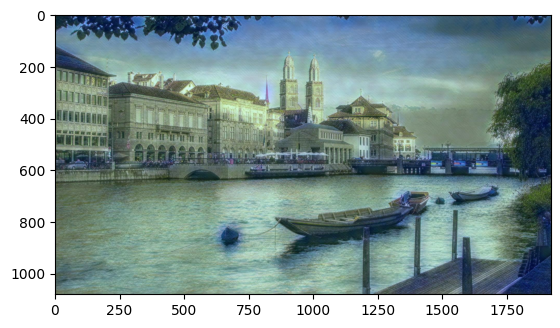

In [17]:
plt.subplot(1, 1, 1)
plt.imshow(Image.open('/Users/macbookpro/aivasovsky-stylized-city.jpeg'))
plt.show()

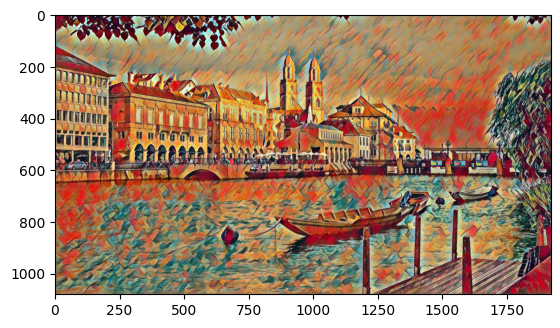

In [5]:
plt.subplot(1, 1, 1)
plt.imshow(Image.open('/Users/macbookpro/kandinskyVII-stylized-city.jpeg'))
plt.show()

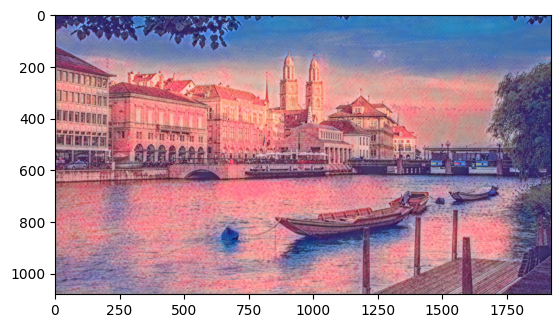

In [14]:
plt.subplot(1, 1, 1)
plt.imshow(Image.open('/Users/macbookpro/akvarel-stylized-city.jpeg'))
plt.show()

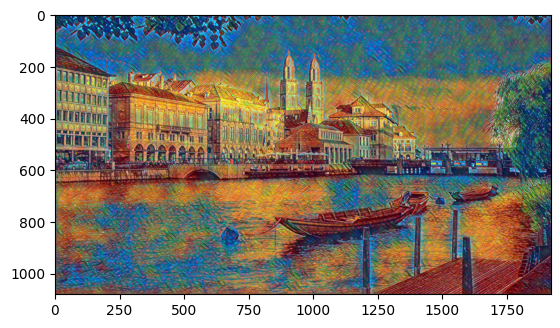

In [13]:
plt.subplot(1, 1, 1)
plt.imshow(Image.open('/Users/macbookpro/kalzado-stylized-city.jpeg'))
plt.show()

## Выводы

Обучение нейронной сети - это крайне увлекательное дело. При запуске обучения нового стиля очень интересен исход обучения, бывает, он оказывается весьма непредсказуем. При виде результата обучения испытываешь неподельный восторг, сразу хочется попробовать обучить модель ещё какому-нибудь стилю. Несмотря на это, процесс обучения на собственном устройстве достаточно долгий - день на стиль. 

Результатами обучения я осталась довольна. От стилевого изображения очень точно берется цветовая гамма, а также достаточно качественно - текстура картины. От контентого изображения чётко сохраняются объекты, часто даже до мельчайших подробностей. Обучение модели считаю успешным.